# Topic: Custumer Clustering with RFM & Clustering Algorithm
## Project 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

# Phần 1:
## 1.Đọc tập tin dữ liệu

In [2]:
data_transactions = pd.read_csv('D:/DL0/project1/GUI_kmeans/Transactions.csv')

In [3]:
data_products = pd.read_csv('D:/DL0/project1/GUI_kmeans/Products_with_Categories.csv')

## 2. Xem thông tin sơ bộ

In [4]:
# Hiển thị 5 dòng đầu tập tin Transactions.csv
data_transactions.head()


,Member_number,Date,productId,items
0,1808,21-07-2015,1,3
1,2552,05-01-2015,2,1
2,2300,19-09-2015,3,3
3,1187,12-12-2015,4,3
4,3037,01-02-2015,2,1


In [5]:
# Hiển thị 5 dòng đầu tập tin Products_with_Categories.csv
data_products.head()

,productId,productName,price,Category
0,1,tropical fruit,7.8,Fresh Food
1,2,whole milk,1.8,Dairy
2,3,pip fruit,3.0,Fresh Food
3,4,other vegetables,0.8,Fresh Food
4,5,rolls/buns,1.2,Bakery & Sweets


In [6]:
# Hiển thị kích thước của dataframe
print(data_products.shape)
print(data_transactions.shape)


(167, 4)
(38765, 4)


In [7]:
# Kiểm tra giá trị thiếu trong data_products
print("Missing values in data_products:")
print(data_products.isnull().sum())

# Kiểm tra giá trị thiếu trong data_transactions
print("\nMissing values in data_transactions:")
print(data_transactions.isnull().sum())


Missing values in data_products:
productId      0
productName    0
price          0
Category       0
dtype: int64

Missing values in data_transactions:
Member_number    0
Date             0
productId        0
items            0
dtype: int64


* không có giá trị nào bị thiếu

In [8]:
data_transactions.info(), data_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Member_number  38765 non-null  int64 
 1   Date           38765 non-null  object
 2   productId      38765 non-null  int64 
 3   items          38765 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    167 non-null    int64  
 1   productName  167 non-null    object 
 2   price        167 non-null    float64
 3   Category     167 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.3+ KB


(None, None)

In [9]:
# Kiểm tra xem có dữ liệu trùng lặp hay không trong Products_with_Categories.csv
if data_products.duplicated().any():
    print("Có dữ liệu trùng lặp trong DataFrame.")
else:
    print("Không có dữ liệu trùng lặp trong DataFrame.")

Không có dữ liệu trùng lặp trong DataFrame.


In [10]:
# Kiểm tra xem có dữ liệu trùng lặp hay không trong Transactions.csv
if data_transactions.duplicated().any():
    print("Có dữ liệu trùng lặp trong DataFrame.")
else:
    print("Không có dữ liệu trùng lặp trong DataFrame.")

Có dữ liệu trùng lặp trong DataFrame.


In [11]:
# Hiển thị các dữ liệu trùng lặp trong data_transactions
duplicate_transactions = data_transactions[data_transactions.duplicated(keep=False)].copy()
duplicate_transactions["index"] = duplicate_transactions.index
duplicate_transactions = duplicate_transactions.sort_values(by=data_transactions.columns[:-1].tolist())

print("Các cặp dòng trùng lặp trong Transactions.csv:")
for _, group in duplicate_transactions.groupby(data_transactions.columns[:-1].tolist()):
    if len(group) > 1:
        print(group[["index"] + data_transactions.columns[:-1].tolist()])
        print("-" * 50)

Các cặp dòng trùng lặp trong Transactions.csv:
       index  Member_number        Date  productId
4769    4769           1026  28-05-2015         22
20918  20918           1026  28-05-2015         22
--------------------------------------------------
       index  Member_number        Date  productId
29972  29972           1045  12-01-2014         18
37270  37270           1045  12-01-2014         18
--------------------------------------------------
       index  Member_number        Date  productId
8090    8090           1052  06-07-2015         18
20687  20687           1052  06-07-2015         18
--------------------------------------------------
       index  Member_number        Date  productId
5475    5475           1132  19-02-2015          4
21624  21624           1132  19-02-2015          4
--------------------------------------------------
       index  Member_number        Date  productId
29826  29826           1133  21-03-2014         71
37124  37124           1133  21-03-

In [12]:
# Nhóm lại theo khách hàng, ngày và sản phẩm để đếm số lần mua
repeat_purchases = data_transactions.groupby(["Member_number", "Date", "productId"]).size().reset_index(name="purchase_count")

# Lọc ra những ai mua nhiều hơn 1 lần
repeat_purchases = repeat_purchases[repeat_purchases["purchase_count"] > 1]

# Hiển thị kết quả
repeat_purchases

,Member_number,Date,productId,purchase_count
39,1003,27-02-2014,5,2
61,1005,09-01-2014,5,2
73,1006,14-06-2015,9,2
83,1008,21-07-2015,18,2
266,1026,28-05-2015,22,2
...,...,...,...,...
37698,4960,19-08-2015,17,2
37751,4968,04-03-2014,8,2
37847,4981,10-01-2015,70,3
37909,4988,29-10-2015,5,2


### Nhận xét:
- Nếu một dòng bị trùng lặp, điều đó có thể do khách hàng đã thực hiện nhiều giao dịch giống nhau trong cùng một ngày.
- Có thể có khuyến mãi dẫn tới khiến họ muốn đặt riêng để nhận được ưu đãi tốt hơn
## **Ta sẽ xem sét có nên loại bỏ các dòng trùng lặp không**


## 3. Kết hợp hai csv với nhau dựa trên productId

In [13]:
# Merge transactions với products dựa trên productId
merged_data = pd.merge(data_transactions, data_products, on="productId", how="left")

# Hiển thị 5 dòng đầu tiên để kiểm tra
merged_data.head()


,Member_number,Date,productId,items,productName,price,Category
0,1808,21-07-2015,1,3,tropical fruit,7.8,Fresh Food
1,2552,05-01-2015,2,1,whole milk,1.8,Dairy
2,2300,19-09-2015,3,3,pip fruit,3.0,Fresh Food
3,1187,12-12-2015,4,3,other vegetables,0.8,Fresh Food
4,3037,01-02-2015,2,1,whole milk,1.8,Dairy


In [14]:
merged_data.shape

(38765, 7)


# Phần 2: EDA

## Xác định các biến định tính và in thông tin

In [15]:
merged_data.head(5)

,Member_number,Date,productId,items,productName,price,Category
0,1808,21-07-2015,1,3,tropical fruit,7.8,Fresh Food
1,2552,05-01-2015,2,1,whole milk,1.8,Dairy
2,2300,19-09-2015,3,3,pip fruit,3.0,Fresh Food
3,1187,12-12-2015,4,3,other vegetables,0.8,Fresh Food
4,3037,01-02-2015,2,1,whole milk,1.8,Dairy


In [16]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Member_number  38765 non-null  int64  
 1   Date           38765 non-null  object 
 2   productId      38765 non-null  int64  
 3   items          38765 non-null  int64  
 4   productName    38765 non-null  object 
 5   price          38765 non-null  float64
 6   Category       38765 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 2.1+ MB


In [17]:
cat_cols = merged_data.select_dtypes(include=['object']).columns
cat_cols

Index(['Date', 'productName', 'Category'], dtype='object')

In [18]:
for col in cat_cols:
    print(col, merged_data[col].nunique())

Date 728
productName 167
Category 11


### Thông tin

- **productName**: Tên của sản phẩm mà khách hàng đã mua.
- **Category**: Nhóm danh mục mà sản phẩm thuộc về.
- **Date**: Nên mang định dạng thời gian chứ không phải Object. -> chuyển về Date


## Chuyển định dạng cột "Date"

In [19]:
# Kiểm tra kiểu dữ liệu của cột 'day'
merged_data['Date'].head(10)


0    21-07-2015
1    05-01-2015
2    19-09-2015
3    12-12-2015
4    01-02-2015
5    14-02-2015
6    08-05-2015
7    23-12-2015
8    20-03-2015
9    12-02-2015
Name: Date, dtype: object

* định dạng theo ngày/tháng/năm

In [20]:
string_to_date = lambda x : datetime.strptime(x, "%d-%m-%Y").date()

# Convert InvoiceDate from object to datetime format
merged_data['Date'] = merged_data['Date'].apply(string_to_date)
merged_data['Date'] = merged_data['Date'].astype('datetime64[ns]')

# Drop NA values
merged_data = merged_data.dropna()

In [21]:
# Kiểm tra kiểu dữ liệu của cột 'day'
merged_data['Date'].head(10)


0   2015-07-21
1   2015-01-05
2   2015-09-19
3   2015-12-12
4   2015-02-01
5   2015-02-14
6   2015-05-08
7   2015-12-23
8   2015-03-20
9   2015-02-12
Name: Date, dtype: datetime64[ns]

* Đã chuyển về dạng datetime64

In [22]:
# Kiểm tra còn day trong biến định tính không
cat_cols = merged_data.select_dtypes(include=['object']).columns
cat_cols

Index(['productName', 'Category'], dtype='object')

## Xác định các biến định lượng và in thông tin

In [23]:
num_cols = merged_data.select_dtypes(include=['number']).columns
num_cols

Index(['Member_number', 'productId', 'items', 'price'], dtype='object')

In [24]:
for col in num_cols:
    print(col, merged_data[col].nunique())

Member_number 3898
productId 167
items 3
price 90


#### Thông tin khách hàng

- **Member_number**: ID duy nhất của khách hàng.

#### Thông tin sản phẩm
- **productId**: ID của sản phẩm.
- **items**:  Số lượng sản phẩm mua trong một giao dịch.
- **price**: Giá của sản phẩm.

In [25]:
merged_data.head()

,Member_number,Date,productId,items,productName,price,Category
0,1808,2015-07-21,1,3,tropical fruit,7.8,Fresh Food
1,2552,2015-01-05,2,1,whole milk,1.8,Dairy
2,2300,2015-09-19,3,3,pip fruit,3.0,Fresh Food
3,1187,2015-12-12,4,3,other vegetables,0.8,Fresh Food
4,3037,2015-02-01,2,1,whole milk,1.8,Dairy


In [26]:
# Kiểm tra khoảng thời gian của dữ liệu
min_date = merged_data['Date'].min().date()
max_date = merged_data['Date'].max().date()
print(f'Transactions timeframe from {min_date} to {max_date}')

Transactions timeframe from 2014-01-01 to 2015-12-30


* Dữ liệu trong khoảng 24 tháng từ năm 2014-2015

In [27]:
# Kiểm tra giao dịch không có Member_number
missing_customer_ids = merged_data['Member_number'].isnull().sum()
print(f'{missing_customer_ids:,} transactions don\'t have a Member_number')

0 transactions don't have a Member_number


In [28]:
# Đếm số lượng khách hàng duy nhất
unique_customers = merged_data['Member_number'].nunique()
print(f'{unique_customers:,} unique Member_number')

3,898 unique Member_number


1. Dữ liệu giao dịch có trong khoảng từ 01/11/2014 đến 30/12/2015. Khoảng thời gian này kéo dài 24 tháng, đủ dài để phân tích xu hướng mua hàng.
* cần chú ý đến ngày cuối cùng (30/12/2015) vì đó sẽ là mốc tham chiếu để tính Recency.
2. Không có giao dịch ẩn danh
* Điều này giúp ích rất nhiều cho phân tích RFM, vì mỗi giao dịch đều có thể được liên kết với một khách hàng cụ thể.
3. Số lượng khách hàng duy nhất: 3,898
* Có 3,898 khách hàng duy nhất đã mua hàng trong khoảng thời gian 24 tháng.


# RFM (Recency - Frequency - Monetary)

# Chọn cột cho RFM Analysis

## 1. Recency (R) – Đánh giá thời gian từ lần mua gần nhất
- **Cột cần dùng:**
  - **Member_number**: Xác định từng khách hàng duy nhất.
  - **Date**: Ngày diễn ra giao dịch.

- **Lý do chọn:**
  - `Date` giúp xác định ngày mua gần nhất của mỗi khách hàng.
  - Khoảng cách giữa ngày gần nhất này và ngày phân tích cho ta giá trị Recency.

- **🔹 Cách tính Recency:**
  - Xác định ngày mua hàng cuối cùng của mỗi khách hàng.
  - Tính số ngày từ lần mua gần nhất đến ngày phân tích.

---

## 2. Frequency (F) – Đánh giá số lần mua hàng
- **Cột cần dùng:**
  - **Member_number**: Xác định từng khách hàng.
  - **Date**: Dùng để đếm số lần khách hàng đã mua hàng.

- **Lý do chọn:**
  - Frequency được tính bằng số lần khách hàng có giao dịch trong tập dữ liệu.
  - Ta đếm số lần `Date` xuất hiện cho từng `Member_number`.

---

## 3. Monetary (M) – Đánh giá tổng số tiền đã chi tiêu
- **Cột cần dùng:**
  - **Member_number**: Xác định từng khách hàng.
  - **price**: Giá của từng sản phẩm.
  - **items**: Số lượng sản phẩm mua.

- **Lý do chọn:**
  - Monetary = Tổng số tiền mà khách hàng đã chi tiêu.
  - ta tính:
    - **Tổng tiền = price × items**


In [29]:
merged_data["total_price"] = merged_data["price"] * merged_data["items"]


In [30]:
merged_data.head()


,Member_number,Date,productId,items,productName,price,Category,total_price
0,1808,2015-07-21,1,3,tropical fruit,7.8,Fresh Food,23.4
1,2552,2015-01-05,2,1,whole milk,1.8,Dairy,1.8
2,2300,2015-09-19,3,3,pip fruit,3.0,Fresh Food,9.0
3,1187,2015-12-12,4,3,other vegetables,0.8,Fresh Food,2.4
4,3037,2015-02-01,2,1,whole milk,1.8,Dairy,1.8


### Tổng doanh thu theo năm

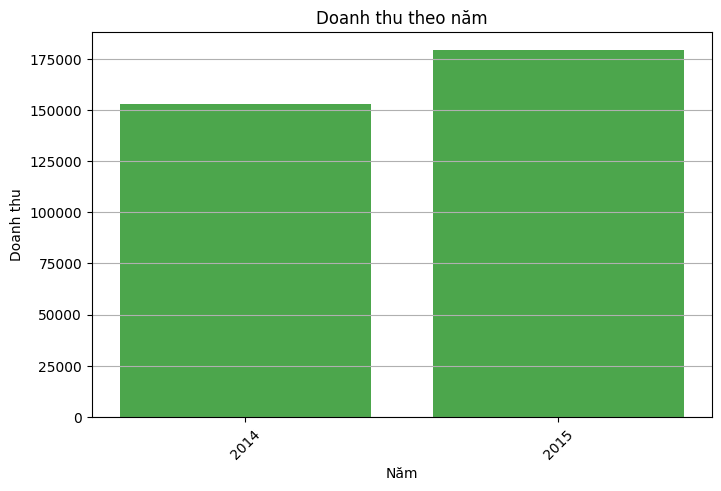

In [31]:

merged_data['Year'] = merged_data['Date'].dt.year

# Tổng doanh thu theo năm
revenue_by_year = merged_data.groupby('Year')['total_price'].sum()

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
plt.bar(revenue_by_year.index.astype(str), revenue_by_year.values, color='g', alpha=0.7)

plt.xlabel('Năm')
plt.ylabel('Doanh thu')
plt.title('Doanh thu theo năm')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


### Doanh thu theo thời gian

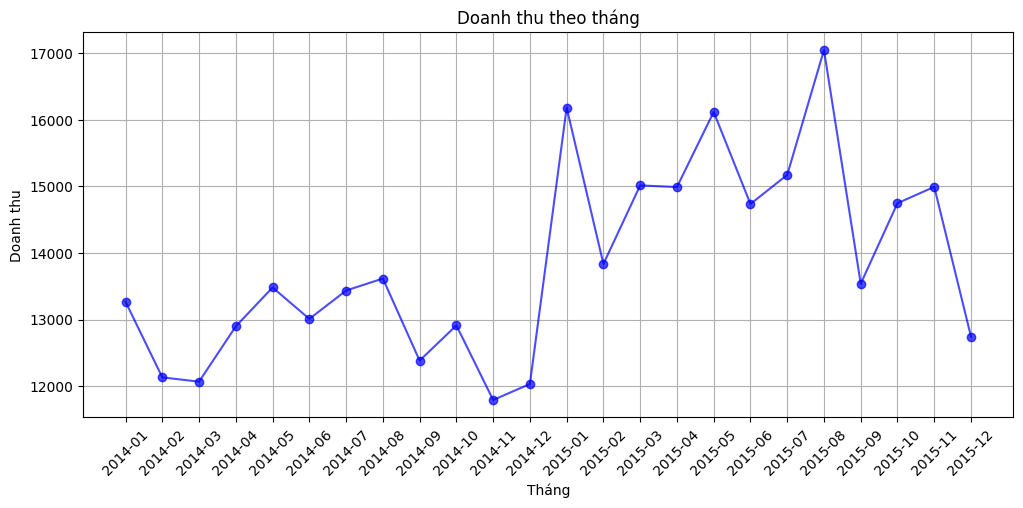

In [32]:
# Nhóm theo tháng
merged_data['YearMonth'] = merged_data['Date'].dt.to_period('M')
revenue_by_month = merged_data.groupby('YearMonth')['total_price'].sum()

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 5))
plt.plot(revenue_by_month.index.astype(str), revenue_by_month.values, marker='o', linestyle='-', color='b', alpha=0.7)

plt.xlabel('Tháng')
plt.ylabel('Doanh thu')
plt.title('Doanh thu theo tháng')
plt.xticks(rotation=45)
plt.grid()
plt.show()


# Phân tích hai biểu đồ doanh thu theo thời gian

## 1. Biểu đồ doanh thu theo năm (Hình 1 - Biểu đồ cột)
- **Tổng quan:**  
  Biểu đồ này hiển thị tổng doanh thu theo năm (2014 và 2015).

- **Nhận xét:**  
  - Năm 2015 có doanh thu cao hơn năm 2014, chứng tỏ hoạt động kinh doanh tăng trưởng.  
  - Mức tăng trưởng không quá mạnh, chỉ tăng từ khoảng 150,000 lên 180,000 (tăng khoảng 20%).  

- **Nguyên nhân:**  
  Điều này có thể do số lượng giao dịch hoặc giá trị đơn hàng trung bình trong năm 2015 tăng so với năm 2014.

---

## 2. Biểu đồ doanh thu theo tháng (Hình 2 - Biểu đồ đường)
- **Tổng quan:**  
  Biểu đồ này cho thấy sự biến động của doanh thu từng tháng trong giai đoạn 2014 - 2015.

- **Nhận xét:**  
  - Doanh thu có nhiều biến động, không ổn định.  
  - Một số tháng đạt đỉnh cao nhưng sau đó giảm mạnh.  

- **Giai đoạn nổi bật:**  
  - Một số tháng có doanh thu rất cao, đặc biệt là tháng 8/2015, đây có thể là mùa cao điểm (sale, lễ hội, khuyến mãi).  
  - Xu hướng chung cho thấy năm 2015 có doanh thu cao hơn 2014, nhưng vẫn có sự dao động mạnh.

---

## Kết luận
1. **Xu hướng chung:**  
   - Doanh thu có xu hướng tăng trưởng qua các năm, nhưng vẫn có sự dao động theo tháng.

2. **Giai đoạn cao điểm:**  
   - Một số tháng như 8/2015 có doanh thu rất cao, có thể do chiến dịch khuyến mãi hoặc mùa cao điểm mua sắm.

3. **Khuyến nghị:**  
   - Nên phân tích kỹ hơn tại sao một số tháng có doanh thu cao đột biến để có thể tối ưu chiến lược kinh doanh, duy trì doanh thu ổn định hơn.


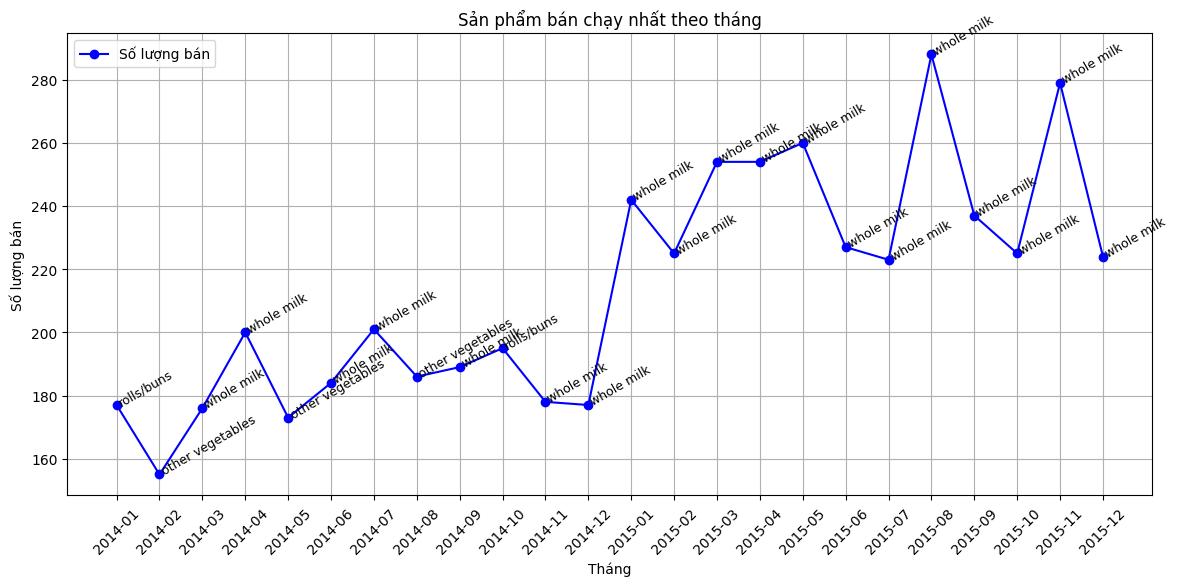

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Chuyển đổi cột 'Date' thành định dạng datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data['YearMonth'] = merged_data['Date'].dt.to_period('M')

# Nhóm theo tháng và sản phẩm, tính tổng số lượng bán
monthly_sales = merged_data.groupby(['YearMonth', 'productName'])['items'].sum().reset_index()

# Lọc ra sản phẩm bán chạy nhất mỗi tháng
top_products = monthly_sales.loc[monthly_sales.groupby('YearMonth')['items'].idxmax()]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(top_products['YearMonth'].astype(str), top_products['items'], marker='o', linestyle='-', color='b', label='Số lượng bán')
plt.xlabel('Tháng')
plt.ylabel('Số lượng bán')
plt.title('Sản phẩm bán chạy nhất theo tháng')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

# Gắn nhãn tên sản phẩm lên điểm dữ liệu
for i, txt in enumerate(top_products['productName']):
    plt.annotate(txt, (top_products['YearMonth'].astype(str).iloc[i], top_products['items'].iloc[i]), fontsize=9, rotation=30)

plt.show()


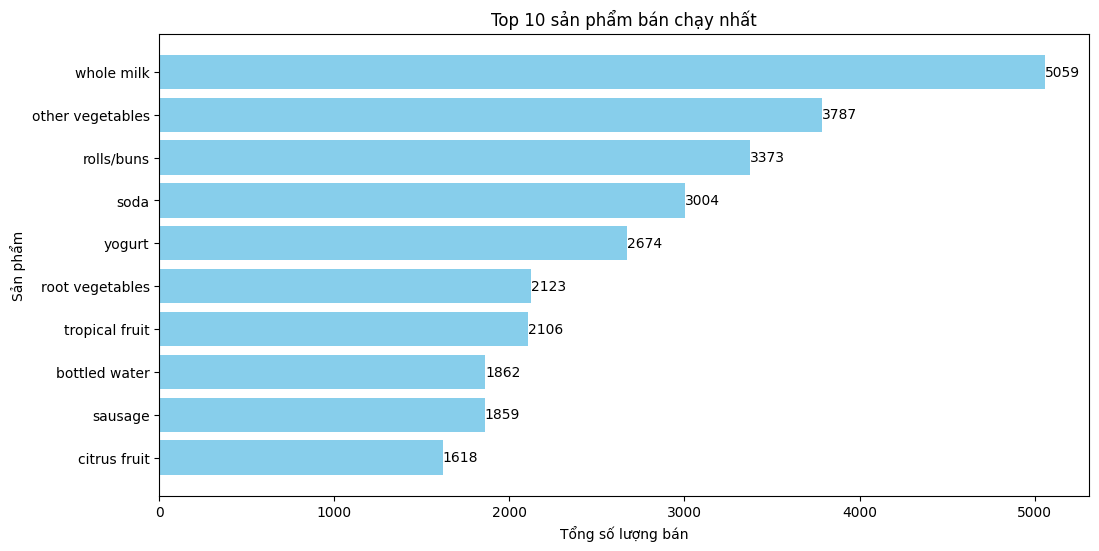

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Nhóm theo sản phẩm và tính tổng số lượng bán
product_sales = merged_data.groupby('productName')['items'].sum().reset_index()

# Sắp xếp giảm dần theo số lượng bán
top_products = product_sales.sort_values(by='items', ascending=False).head(10)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.barh(top_products['productName'], top_products['items'], color='skyblue')
plt.xlabel('Tổng số lượng bán')
plt.ylabel('Sản phẩm')
plt.title('Top 10 sản phẩm bán chạy nhất')
plt.gca().invert_yaxis()  # Đảo ngược trục Y để sản phẩm bán chạy nhất ở trên cùng

# Hiển thị số lượng bán trên từng cột
for index, value in enumerate(top_products['items']):
    plt.text(value, index, str(value), va='center')

plt.show()


# Phân tích biểu đồ

## Biểu đồ đường (hình đầu tiên)
- **Trục hoành (X):** Hiển thị các tháng từ tháng 1/2014 đến tháng 12/2015.
- **Trục tung (Y):** Hiển thị số lượng bán ra của sản phẩm bán chạy nhất trong từng tháng.
- **Các điểm:**
  - Thể hiện sản phẩm có số lượng bán cao nhất trong tháng đó.
  - Nhãn ghi trên từng điểm thể hiện tên sản phẩm bán chạy nhất.

### Nhận xét:
- Sản phẩm **"whole milk"** (sữa nguyên kem) là sản phẩm bán chạy nhất trong nhiều tháng.
- Phân tích này giúp xác định sản phẩm chủ lực và xu hướng mua hàng.

---

## Biểu đồ cột ngang (hình thứ hai)
- **Trục hoành (X):** Hiển thị tổng số lượng sản phẩm đã bán.
- **Trục tung (Y):** Hiển thị tên các sản phẩm.
- **Thanh ngang:** Biểu diễn tổng số lượng bán của từng sản phẩm, giúp dễ dàng so sánh mức độ phổ biến.

### Nhận xét:
- **"whole milk"** là sản phẩm bán chạy nhất với hơn 5000 đơn vị bán ra.
- Tiếp theo là **"other vegetables"** (rau củ khác) và **"rolls/buns"** (bánh mì, bánh cuộn).
- Biểu đồ này cung cấp cái nhìn tổng quan về sự phổ biến của từng sản phẩm.


In [35]:
# ---- Tính toán RFM ----
Recency = lambda x: (max_date - x.max().date()).days  # Số ngày từ lần mua gần nhất
Frequency = lambda x: x.count()  # Số lần khách hàng có giao dịch
Monetary = lambda x: round(x.sum(), 2)  # Tổng tiền khách hàng chi tiêu


# Tạo bảng RFM
df_RFM = merged_data.groupby('Member_number').agg(
    Recency=('Date', Recency),  # Tính Recency dựa trên cột Date
    Frequency=('Date', Frequency),  # Tính Frequency dựa trên số lượng Date duy nhất
    Monetary=('total_price', Monetary)  # Tính Monetary dựa trên tổng tiền (total_price)
)

In [36]:
df_RFM.head()

,Recency,Frequency,Monetary
Member_number,,,
1000,35,13,53.80
1001,242,12,100.00
1002,122,8,70.30
1003,323,8,60.65
1004,28,21,204.96


In [37]:
# Descending Sorting
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
df_RFM.head()

,Recency,Frequency,Monetary
Member_number,,,
2433,3,31,375.31
2193,91,27,361.45
1793,26,25,345.10
3289,4,29,334.15
2743,142,17,312.46


# Nhận xét về output 5 dòng đầu của RFM Analysis

## Phân tích dữ liệu

### Khách hàng có `Member_number = 2433`:
- **Monetary:** 375.31 (chi tiêu nhiều nhất trong nhóm).
- **Recency:** 3 (mua hàng rất gần đây, là khách hàng tích cực).
- **Frequency:** 31 (số lần mua hàng nhiều nhất, khách hàng trung thành).

### Khách hàng có `Member_number = 2193`:
- **Monetary:** 361.45 (chi tiêu cao, nhưng thấp hơn khách hàng top 1).
- **Recency:** 91 (đã không mua hàng trong 91 ngày, có thể là khách hàng lâu năm nhưng gần đây ít quay lại).
- **Frequency:** 27 (số lần mua hàng khá nhiều, nhưng ít hơn khách hàng top 1).

### Khách hàng có `Member_number = 1793`:
- **Monetary:** 345.10.
- **Recency:** 26 (gần đây có mua hàng, nhưng không quá thường xuyên).
- **Frequency:** 25 (số lần mua hàng ở mức trung bình).

### Khách hàng có `Member_number = 3289`:
- **Monetary:** 334.15.
- **Recency:** 4 (mới mua hàng gần đây).
- **Frequency:** 29 (mua hàng khá thường xuyên, chỉ đứng sau khách hàng top 1).

### Khách hàng có `Member_number = 2743`:
- **Monetary:** 312.46 (chi tiêu thấp nhất trong nhóm).
- **Recency:** 142 (đã lâu không mua hàng, có thể là khách hàng đang rời đi).
- **Frequency:** 17 (số lần mua hàng thấp nhất trong nhóm).

---

## Kết luận & Gợi ý

### Khách hàng `Member_number = 2433`:
- Là khách hàng trung thành nhất với số lần mua hàng nhiều nhất và chi tiêu cao nhất.
- Nên được ưu tiên trong chương trình khách hàng thân thiết hoặc VIP.

### Khách hàng `Member_number = 2193`:
- Đã lâu không quay lại mua hàng (**Recency = 91**).
- Cần chiến dịch tiếp thị nhắc nhở hoặc ưu đãi để kéo họ quay lại.

### Khách hàng `Member_number = 3289`:
- Tích cực mua hàng gần đây nhưng chi tiêu không quá cao.
- Có thể nhắm đến với chương trình tăng giá trị đơn hàng, như giảm giá khi mua nhiều hơn.

### Khách hàng `Member_number = 2743`:
- Đã không mua hàng trong **142 ngày**, có nguy cơ rời bỏ thương hiệu.
- Cần chiến dịch tiếp cận lại, có thể là phiếu giảm giá hoặc lời mời đặc biệt để kích thích quay lại.


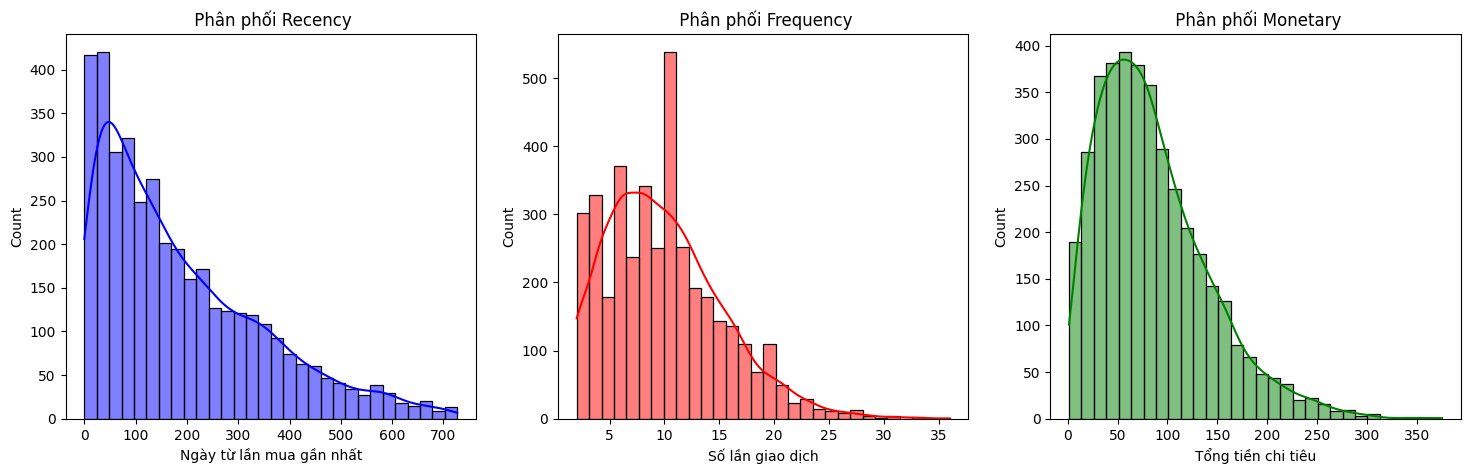

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
sns.histplot(df_RFM["Recency"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title(" Phân phối Recency")
axes[0].set_xlabel("Ngày từ lần mua gần nhất")

# Frequency
sns.histplot(df_RFM["Frequency"], bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title(" Phân phối Frequency")
axes[1].set_xlabel("Số lần giao dịch")

# Monetary
sns.histplot(df_RFM["Monetary"], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title(" Phân phối Monetary")
axes[2].set_xlabel("Tổng tiền chi tiêu")

plt.show()


# Nhận xét về biểu đồ phân phối của RFM Analysis

## Biểu đồ Recency (Số ngày từ lần mua gần nhất)
- **Phân phối:** Lệch phải, với phần lớn khách hàng có giá trị Recency nhỏ (dưới 100 ngày).
- **Ý nghĩa:** Nhiều khách hàng đã mua hàng gần đây, nhưng vẫn có một số lượng nhỏ khách hàng không mua hàng trong thời gian dài (> 300 ngày).
- **Gợi ý:**
  - Thực hiện các chiến dịch tiếp thị để thu hút lại nhóm khách hàng đã lâu không quay lại.

---

## Biểu đồ Frequency (Số lần mua hàng)
- **Phân phối:** Lệch phải, phần lớn khách hàng có số lần mua từ 5 đến 15 lần.
- **Ý nghĩa:**
  - Có rất ít khách hàng mua hàng nhiều hơn 20 lần, điều này có thể do sản phẩm không có tính chất mua lặp lại thường xuyên.
- **Gợi ý:**
  - Khuyến khích khách hàng tăng tần suất mua qua chương trình khách hàng thân thiết hoặc ưu đãi cho lần mua tiếp theo.

---

## Biểu đồ Monetary (Tổng tiền chi tiêu)
- **Phân phối:** Lệch phải, với phần lớn khách hàng chi tiêu trong khoảng 20 - 150 đơn vị tiền tệ.
- **Ý nghĩa:**
  - Một số ít khách hàng có chi tiêu rất cao (> 200), cho thấy có nhóm khách hàng VIP hoặc mua sắm nhiều.
- **Gợi ý:**
  - Khai thác nhóm khách hàng này bằng chương trình ưu đãi đặc biệt để giữ chân họ.


## Vẽ Boxplot để phát hiện Outliers

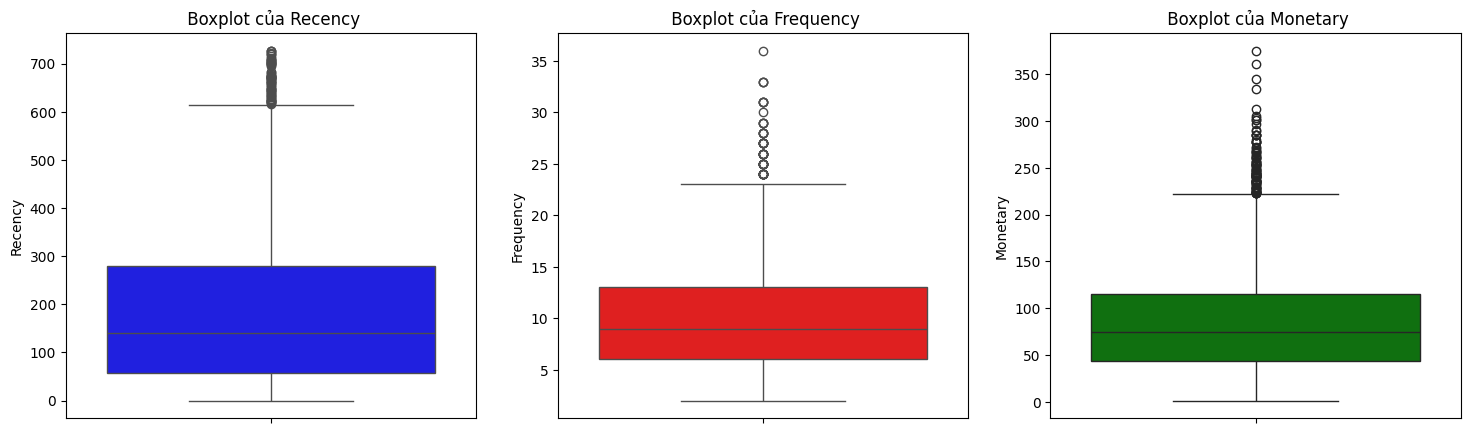

In [39]:
# Vẽ Boxplot cho từng chỉ số RFM
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
sns.boxplot(y=df_RFM["Recency"], ax=axes[0], color="blue")
axes[0].set_title(" Boxplot của Recency")

# Frequency
sns.boxplot(y=df_RFM["Frequency"], ax=axes[1], color="red")
axes[1].set_title(" Boxplot của Frequency")

# Monetary
sns.boxplot(y=df_RFM["Monetary"], ax=axes[2], color="green")
axes[2].set_title(" Boxplot của Monetary")

plt.show()


1. Biến Recency:
- Có nhiều giá trị ngoại lai (outliers) phía trên, đặc biệt là các điểm trên 600, thậm chí có một số trên 700. Một số khách hàng có giá trị Recency rất cao (>600 ngày), tức là họ không mua hàng trong một thời gian dài.
2. Biến Frequency
- Có nhiều giá trị ngoại lai ở phần trên, có khách hàng có số lần mua hàng lên tới 35+ lần. Một nhóm nhỏ khách hàng mua hàng với tần suất rất cao (>25 lần), có thể là khách hàng trung thành hoặc doanh nghiệp mua số lượng lớn.
3. Biến Monetary
- Có rất nhiều ngoại lai ở phía trên, có khách hàng chi tiêu trên 350 đơn vị tiền tệ. Một số khách hàng chi tiêu rất lớn (>250), có thể là khách hàng VIP hoặc khách hàng doanh nghiệp.

# Tính 4 nhóm quartiles

In [40]:
r_labels = range(4, 0, -1)  # Recency: số ngày từ lần mua hàng cuối cùng càng nhỏ càng tốt, nên gán nhãn lớn hơn
f_labels = range(1, 5)  # Frequency: số lần mua hàng càng nhiều càng tốt, gán nhãn từ nhỏ đến lớn
m_labels = range(1, 5)  # Monetary: tổng tiền chi tiêu càng nhiều càng tốt, gán nhãn từ nhỏ đến lớn


- Recency (R): Số ngày kể từ lần mua hàng cuối cùng. Nhỏ hơn → tốt hơn (khách hàng mới mua gần đây hơn). Gán điểm cao hơn cho khách hàng có Recency nhỏ hơn (4 là tốt nhất, 1 là kém nhất).
- Frequency (F): Số lần mua hàng. Càng lớn → càng tốt (khách hàng trung thành, mua thường xuyên hơn). Gán điểm cao hơn cho khách hàng có Frequency cao hơn (4 là tốt nhất, 1 là kém nhất).
- Monetary (M): Tổng số tiền khách hàng đã chi tiêu. Càng lớn → càng tốt (khách hàng chi tiêu nhiều). Gán điểm cao hơn cho khách hàng có Monetary cao hơn (4 là tốt nhất, 1 là kém nhất).

In [41]:
# Gán các nhãn này cho 4 nhóm phần trăm bằng nhau
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)

f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)

m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [42]:
# Create new columns R, F, M
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
Member_number,,,,,,
2433,3,31,375.31,4,4,4
2193,91,27,361.45,3,4,4
1793,26,25,345.10,4,4,4
3289,4,29,334.15,4,4,4
2743,142,17,312.46,2,4,4


#### Dựa vào 5 khách hàng này ta thấy:
- Khách hàng có R = 4 (VD: 2433, 1793, 3289) có lần mua hàng gần đây nhất, điều này cho thấy họ là những khách hàng tiềm năng.
- Khách hàng trong danh sách đều có F = 4, nghĩa là họ mua hàng rất nhiều lần, cho thấy mức độ trung thành cao.
- Khách hàng trong danh sách đều có M = 4, có nghĩa là họ là khách hàng có giá trị cao, đóng góp lớn vào doanh thu của doanh nghiệp.

# Định nghĩa tập luật

In [43]:
def rfm_level(df):
    if df['R'] >= 3 and df['F'] >= 3 and df['M'] >= 3:
        return 'VIP'  # Khách hàng giá trị cao, mua thường xuyên, gần đây

    elif df['R'] >= 3 and df['F'] <= 2:
        return 'NEW'  # Mới mua gần đây nhưng chưa mua nhiều

    elif df['R'] <= 2 and df['F'] >= 3:
        return 'LOYAL'  # Mua thường xuyên nhưng không còn mua gần đây

    else:
        return 'CHURN'  # Ít mua, mua đã lâu, ít giá trị



In [44]:

df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Level
Member_number,,,,,,,
2433,3,31,375.31,4,4,4,VIP
2193,91,27,361.45,3,4,4,VIP
1793,26,25,345.10,4,4,4,VIP
3289,4,29,334.15,4,4,4,VIP
2743,142,17,312.46,2,4,4,LOYAL


In [45]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Level,RFM_Score
Member_number,,,,,,,,
2433,3,31,375.31,4,4,4,VIP,12
2193,91,27,361.45,3,4,4,VIP,11
1793,26,25,345.10,4,4,4,VIP,12
3289,4,29,334.15,4,4,4,VIP,12
2743,142,17,312.46,2,4,4,LOYAL,10


RFM_Level
CHURN    1495
VIP      1059
LOYAL     672
NEW       672
Name: count, dtype: int64


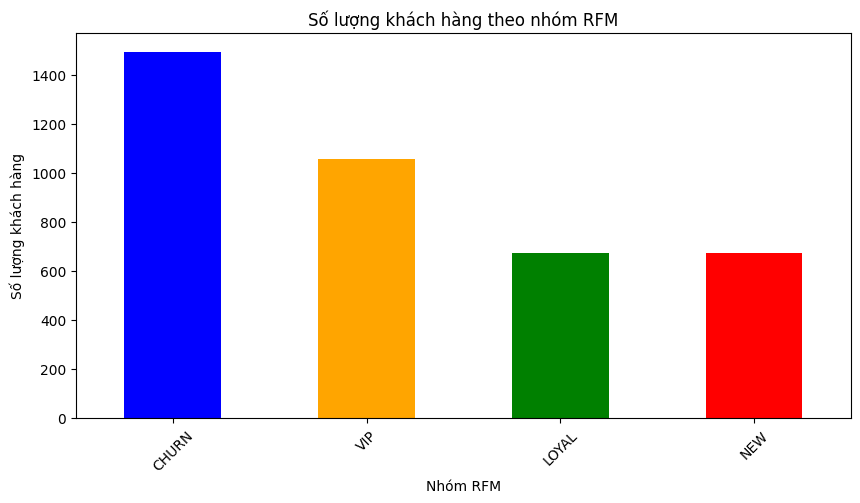

In [46]:
import matplotlib.pyplot as plt

# Đếm số lượng khách hàng theo từng nhóm RFM_Level
rfm_counts = df_RFM['RFM_Level'].value_counts()

print(rfm_counts)

# Vẽ biểu đồ cột thể hiện số lượng khách hàng trong từng nhóm
plt.figure(figsize=(10, 5))
rfm_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])

plt.title('Số lượng khách hàng theo nhóm RFM')
plt.xlabel('Nhóm RFM')
plt.ylabel('Số lượng khách hàng')
plt.xticks(rotation=45)
plt.show()


# CHURN R thấp → đã lâu không mua, F thấp, M thấp, Đây là nhóm đã rời bỏ hoặc không còn tương tác, chiếm tỷ trọng lớn nhất → cần chiến dịch tái kích hoạt
# VIP Nhóm khách hàng giá trị nhất, chi tiêu cao và tương tác thường xuyên → ưu tiên duy trì & chăm sóc
# LOYAL Nhóm trung thành trước đây, gần đây ít mua lại → có thể là khách hàng đang chững lại
# NEW Khách mới mua gần đây nhưng chưa mua nhiều → cần chuyển hóa thành khách trung thành


# Tính trung bình của Recency, Frequency, Monetary cho từng nhóm.

In [47]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [48]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,CHURN,306.0,6.0,48.0,1495,38.35
1,LOYAL,247.0,13.0,110.0,672,17.24
2,NEW,68.0,6.0,57.0,672,17.24
3,VIP,59.0,15.0,139.0,1059,27.17


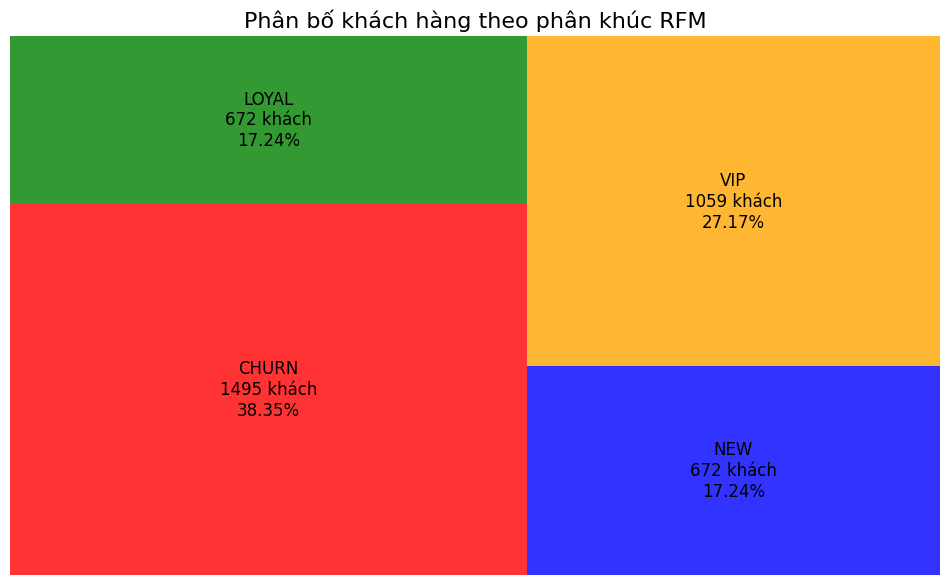

In [49]:
import matplotlib.pyplot as plt
import squarify  # pip install squarify nếu chưa có

# Dữ liệu đầu vào
labels = rfm_agg['RFM_Level'] + "\n" + \
         rfm_agg['Count'].astype(str) + " khách\n" + \
         rfm_agg['Percent'].astype(str) + "%"
sizes = rfm_agg['Count']
colors = ['red', 'green', 'blue', 'orange']  # hoặc chọn theo logic riêng

# Vẽ biểu đồ TreeMap
plt.figure(figsize=(12, 7))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 12})

plt.axis('off')
plt.title("Phân bố khách hàng theo phân khúc RFM", fontsize=16)
plt.show()


## CHURN (đỏ)	1,495 khách	38.35%	Nhóm khách hàng đã rời bỏ, không mua gần đây, ít mua, chi tiêu thấp. Đây là nhóm chiếm tỷ lệ cao nhất → cần chiến dịch tái kích hoạt, remarketing, ưu đãi quay lại.
## VIP (vàng cam)	1,059 khách	27.17%	Nhóm khách hàng giá trị cao nhất: thường xuyên mua, gần đây, chi tiêu lớn → cần chăm sóc đặc biệt, giữ chân bằng loyalty program, upsell/cross-sell.
## LOYAL (xanh lá)	672 khách	17.24%	Nhóm trung thành trước đây, mua nhiều nhưng không còn mua gần đây → cần kích thích quay lại, nhắc nhớ, khuyến mãi targeted.
## NEW (xanh dương)	672 khách	17.24%	Nhóm khách hàng mới mua gần đây, nhưng chưa mua nhiều → tiềm năng chuyển hóa thành VIP nếu được nurturing đúng cách.

In [50]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="MonetaryMean", y="RecencyMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=80)
fig.show()

# Trục Y càng thấp → khách càng mới mua gần đây., Trục X càng cao → khách chi tiêu càng nhiều., Bubble càng to → khách càng mua nhiều lần.

#  Nhìn vào đó ta thấy:

# VIP ở dưới cùng bên phải → tốt nhất toàn diện (chi tiêu, tần suất, gần đây).

# CHURN ở trên cùng bên trái → nhóm kém nhất, mất tương tác.

# NEW và LOYAL nằm ở giữa – là hai nhóm tiềm năng nếu có chiến lược giữ chân/nurture hợp lý.


# RFM + Kmeans

### Kmeans clusters with the Elbow Method

In [51]:
df_now = df_RFM[['Recency','Frequency','Monetary']]

In [52]:
df_now

,Recency,Frequency,Monetary
Member_number,,,
2433,3,31,375.31
2193,91,27,361.45
1793,26,25,345.10
3289,4,29,334.15
2743,142,17,312.46
...,...,...,...
4565,0,2,2.20
3949,273,2,2.10
1560,593,2,1.90


# chuẩn hóa dữ liệu trước khi dùng K-Means

# Đơn vị đo lường khác nhau của Recency, Frequency, Monetary

## Ví dụ về giá trị:
- **Recency (Số ngày kể từ lần mua cuối):**  
  Giá trị thường rất lớn (0 - 700 ngày).

- **Frequency (Số lần mua hàng):**  
  Giá trị nhỏ hơn nhiều (1 - 40 lần).

- **Monetary (Tổng tiền chi tiêu):**  
  Giá trị có thể rất lớn (10 - 1000+ đơn vị tiền tệ).

---

##  Vấn đề:
- K-Means sử dụng khoảng cách Euclidean để tính toán cụm.
- Nếu không chuẩn hóa dữ liệu, **Monetary** sẽ có ảnh hưởng lớn hơn nhiều so với **Recency** và **Frequency**.
- Điều này dẫn đến mất cân bằng cụm, khiến kết quả không chính xác.

---





In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import cdist

In [54]:

# Chuẩn hóa dữ liệu bằng RobustScaler (do có outliers)
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_now)

In [55]:
df_scaled

array([[-0.61883408,  3.14285714,  4.20242009],
       [-0.22421525,  2.57142857,  4.00853326],
       [-0.51569507,  2.28571429,  3.77981395],
       ...,
       [ 2.02690583, -1.        , -1.02119326],
       [ 1.20627803, -1.        , -1.02399105],
       [ 1.37668161, -1.        , -1.02958663]])

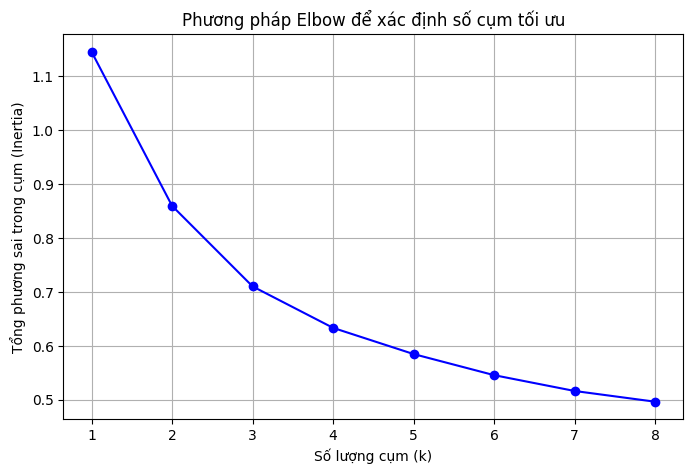

In [56]:
distortions = []
K = range(1, 9)

for k in K:
    kmean_model = KMeans(n_clusters=k, random_state=42)
    kmean_model.fit(df_scaled)
    distortions.append(sum(np.min(cdist(df_scaled, kmean_model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])


# Vẽ biểu đồ Elbow
plt.figure(figsize=(8, 5))
plt.plot(list(K), distortions, marker='o', linestyle='-', color='b')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Tổng phương sai trong cụm (Inertia)')
plt.title('Phương pháp Elbow để xác định số cụm tối ưu')
plt.xticks(list(K))
plt.grid()
plt.show()


In [57]:



optimal_k = 3  # Chọn số cụm từ biểu đồ Elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
df_RFM['Cluster'] = kmeans.fit_predict(df_scaled)

# Xem kết quả phân cụm
df_RFM.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Level,RFM_Score,Cluster
Member_number,,,,,,,,,
2433,3,31,375.31,4,4,4,VIP,12,2
2193,91,27,361.45,3,4,4,VIP,11,2
1793,26,25,345.10,4,4,4,VIP,12,2
3289,4,29,334.15,4,4,4,VIP,12,2
2743,142,17,312.46,2,4,4,LOYAL,10,2


In [58]:
df_now["Cluster"] = kmeans.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

C:\Users\PAT\AppData\Local\Temp\ipykernel_27336\1394860254.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        118.54      8.68    68.10  1930
1        413.85      5.32    42.59   953
2        106.88     16.69   157.78  1015

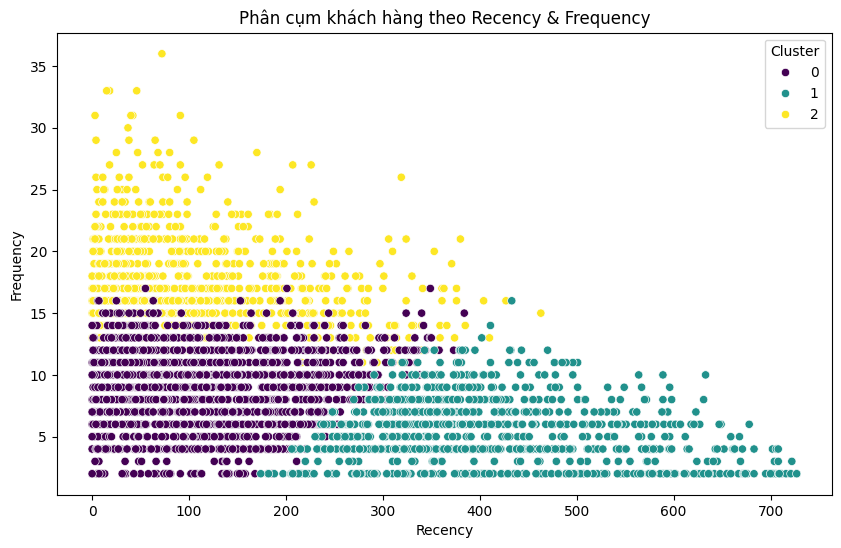

In [59]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_RFM['Recency'], y=df_RFM['Frequency'], hue=df_RFM['Cluster'], palette='viridis')
plt.title('Phân cụm khách hàng theo Recency & Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()


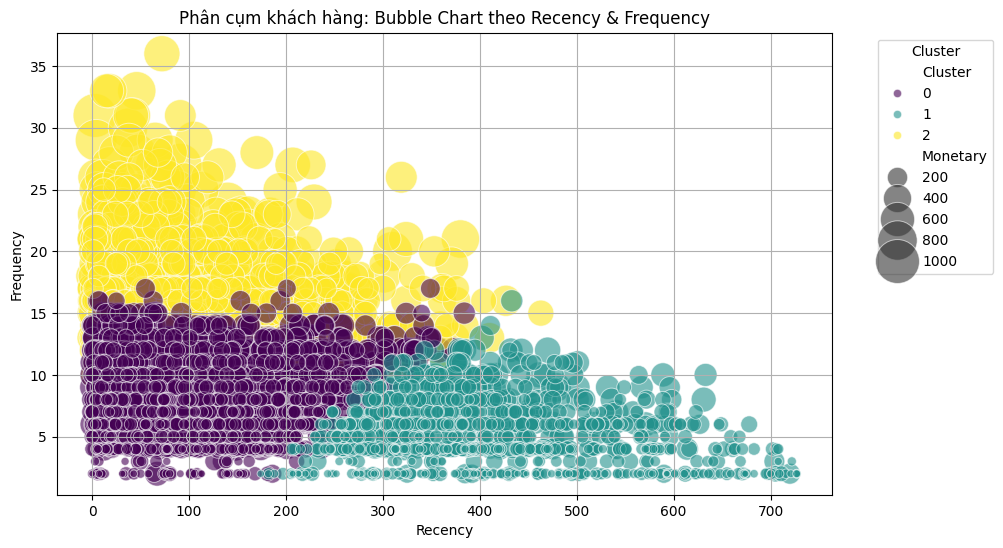

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chuẩn hóa kích thước bubble để dễ hiển thị
bubble_size = df_RFM['Monetary'] / df_RFM['Monetary'].max() * 1000

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_RFM['Recency'],
    y=df_RFM['Frequency'],
    hue=df_RFM['Cluster'],
    size=bubble_size,            # kích thước bubble
    sizes=(20, 1000),            # giới hạn size bubble
    palette='viridis',
    alpha=0.6,
    edgecolor='w'
)
plt.title('Phân cụm khách hàng: Bubble Chart theo Recency & Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [61]:
import plotly.express as px

fig = px.scatter(
    df_RFM,
    x='Recency',
    y='Frequency',
    size='Monetary',                # Kích thước bubble
    color='Cluster',                # Màu theo cụm
    hover_name='Cluster',           # Hiển thị cụm khi hover
    size_max=80,                    # Giới hạn kích thước bubble
    title='Bubble Chart: Recency vs Frequency (size = Monetary)'
)

fig.update_layout(
    xaxis_title='Recency',
    yaxis_title='Frequency',
    legend_title='Cluster'
)

fig.show()


In [62]:
# Cluster 1: CHURN / KHÁCH RỜI BỎ: Nằm cao bên phải (Recency cao, Frequency thấp), Bubble nhỏ (Monetary thấp) → Nhóm khách đã lâu không quay lại, mua ít, chi tiêu thấp=>  Cần tái kích hoạt bằng ưu đãi/remarketing

# Cluster 2: VIP / KHÁCH GIÁ TRỊ CAO: Nằm thấp bên trái, gần trục Y cao (Recency thấp, Frequency cao); Bubble to (Monetary cao) → Nhóm khách mua gần đây, thường xuyên và chi tiêu lớn =>  Cần giữ chân bằng loyalty program, ưu đãi đặc biệt

#  Cluster 0: TRUNG BÌNH / KHÁCH PHỔ THÔNG: Vị trí trung gian, recency không quá cũ, frequency vừa, monetary tầm trung → Nhóm khách có tiềm năng → có thể upsell hoặc khuyến khích mua thường xuyên hơn

# RFM + GMM:


In [63]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

In [64]:
df_now1=df_now.copy()
df_now1

,Recency,Frequency,Monetary,Cluster
Member_number,,,,
2433,3,31,375.31,2
2193,91,27,361.45,2
1793,26,25,345.10,2
3289,4,29,334.15,2
2743,142,17,312.46,2
...,...,...,...,...
4565,0,2,2.20,0
3949,273,2,2.10,1
1560,593,2,1.90,1


In [65]:
# Chuẩn hóa dữ liệu
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_now1)


# Lưu trữ BIC và AIC cho các số lượng phân phối khác nhau
bic = []
aic = []
n_components_range = range(1, 11)  # Thử nghiệm với 1 đến 10 cụm

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df_scaled)
    bic.append(gmm.bic(df_scaled))  # Lưu BIC
    aic.append(gmm.aic(df_scaled))  # Lưu AIC

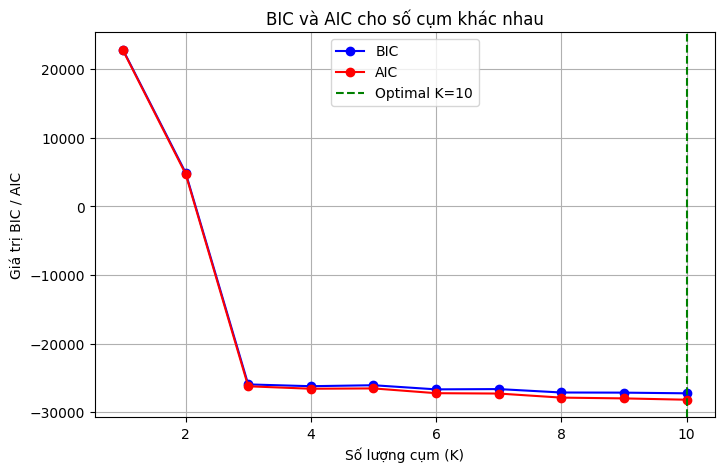

Số cụm tối ưu theo BIC: 10


In [66]:
# Vẽ đồ thị BIC và AIC
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, bic, marker='o', linestyle='-', color='b', label='BIC')
plt.plot(n_components_range, aic, marker='o', linestyle='-', color='r', label='AIC')

# Đánh dấu số cụm tối ưu
optimal_k = n_components_range[np.argmin(bic)]
plt.axvline(optimal_k, linestyle='--', color='g', label=f'Optimal K={optimal_k}')

plt.xlabel('Số lượng cụm (K)')
plt.ylabel('Giá trị BIC / AIC')
plt.title('BIC và AIC cho số cụm khác nhau')
plt.legend()
plt.grid()
plt.show()

print(f"Số cụm tối ưu theo BIC: {optimal_k}")

In [67]:
# Huấn luyện GMM với số cụm tối ưu
gmm_final = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_final.fit(df_scaled)

# Dự đoán nhãn cụm cho từng điểm dữ liệu
labels = gmm_final.predict(df_scaled)

# Thêm nhãn vào dataframe gốc
df_now1['Cluster'] = labels

# Hiển thị kết quả
df_now1



,Recency,Frequency,Monetary,Cluster
Member_number,,,,
2433,3,31,375.31,2
2193,91,27,361.45,2
1793,26,25,345.10,2
3289,4,29,334.15,2
2743,142,17,312.46,2
...,...,...,...,...
4565,0,2,2.20,9
3949,273,2,2.10,7
1560,593,2,1.90,7


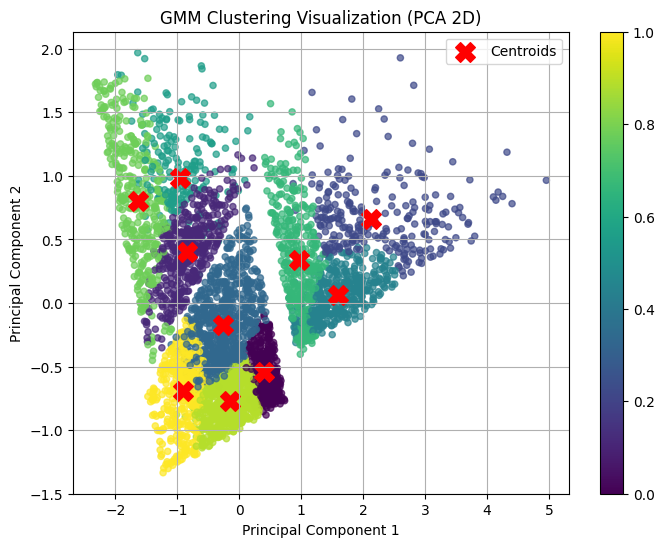

In [68]:
from sklearn.decomposition import PCA


# Giảm chiều dữ liệu từ 4D xuống 2D
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Vẽ biểu đồ scatter 2D
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', s=20, alpha=0.7)
plt.scatter(pca.transform(gmm_final.means_)[:, 0], pca.transform(gmm_final.means_)[:, 1],
            c='red', marker='X', s=200, label='Centroids')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('GMM Clustering Visualization (PCA 2D)')
plt.legend()
plt.grid()
plt.colorbar()
plt.show()


In [69]:
import plotly.express as px
import pandas as pd
import numpy as np

# Tạo DataFrame từ PCA kết quả
df_pca_plot = pd.DataFrame({
    'PC1': df_pca[:, 0],
    'PC2': df_pca[:, 1],
    'Cluster': labels.astype(str)  # đổi sang chuỗi để màu dễ phân biệt
})

# Thêm điểm centroid (center của GMM) đã PCA transform
centroids_pca = pca.transform(gmm_final.means_)
df_centroids = pd.DataFrame({
    'PC1': centroids_pca[:, 0],
    'PC2': centroids_pca[:, 1],
    'Cluster': ['Centroid'] * len(centroids_pca)
})

# Vẽ scatter plot tương tác
fig = px.scatter(
    df_pca_plot,
    x='PC1',
    y='PC2',
    color='Cluster',
    title='GMM Clustering Visualization (PCA 2D)',
    opacity=0.7,
    width=800,
    height=600
)

# Vẽ thêm các centroid (màu đỏ, marker X)
fig.add_scatter(
    x=df_centroids['PC1'],
    y=df_centroids['PC2'],
    mode='markers',
    marker=dict(size=15, color='red', symbol='x'),
    name='Centroids'
)

fig.update_layout(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    legend_title='Cluster'
)

fig.show()


- Đã thực hiện giảm chiều dữ liệu và nhóm được 3 nhóm khách hàng.
Phân cụm khách hàng thành 3 nhóm chính:
- **VIP / GIÁ TRỊ CAO (Cluster 0)**: Khách hàng mua gần đây, thường xuyên và chi tiêu cao.
- **CHURN / KHÁCH RỜI BỎ (Cluster 1)**: Khách đã lâu không quay lại, mua ít và chi tiêu thấp.
- **TRUNG BÌNH / PHỔ THÔNG (Cluster 2)**: Khách ở mức trung bình, có tiềm năng để phát triển thêm.

In [70]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import joblib

# Chỉ chọn 3 cột gốc để fit
X = df_RFM[["Recency", "Frequency", "Monetary"]]

# Huấn luyện lại scaler và model
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Lưu lại mô hình đúng
joblib.dump(scaler, "rfm_scaler.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")


['kmeans_model.pkl']

In [71]:
import joblib
scaler = joblib.load("rfm_scaler.pkl")
print(scaler.feature_names_in_)


['Recency' 'Frequency' 'Monetary']


In [72]:
import joblib

# Lưu dữ liệu RFM đã chuẩn bị
joblib.dump(df_RFM, "rfm_data.pkl")


['rfm_data.pkl']